In [1]:
import pandas as pd
import pyarrow.dataset as ds
import os, psutil
import pickle
import numpy as np
import astropy.units as u
import dask.dataframe as dd
import matplotlib.pyplot as plt
process = psutil.Process(os.getpid())

In [123]:
from main import SimCatVal
from sim import make_sim
import numpy as np
from utils import sample_position, sample_diff_position
import pickle

ind = 73 #this has the big galaxies
skycat_path="/hildafs/home/pladuca/main/skyCatalog.yaml"
Dp1_sample="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs/ECDFS_3000_psf.pkl"
im_size=900
save_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff"
diff_path="/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/diffsky_new"

with open(Dp1_sample, 'rb') as f:
    rsp_sample = pickle.load(f)

position = sample_position(1001, 223)
ra = position[ind-1][0]
dec = position[ind-1][1]
sample = rsp_sample[ind-1].copy()
sample.pop('ra')
sample.pop('dec')

diff_position = sample_diff_position(1001, 223, diff_path)
diff_ra = diff_position[ind-1][0]
diff_dec = diff_position[ind-1][1]
samp = {'i':sample['i']}

# afw_dic, truths, npy_dic = make_sim(skycat_path, ra, dec, 900, 50, samp, 31.4, diff_path, diff_ra, diff_dec)

# afw_dic, truths, ims, area = SimCatVal(skycat_path,ra,dec,im_size,50,samp,31.4,ind,save_path,)#'diffsky_1deg.pickle',diff_ra,diff_dec)
# afw_dic_, npy_dic_, cats_, truths_, area_ = SimCatVal(skycat_path,ra,dec,im_size,50,samp,31.4,ind,save_path,'diffsky_1deg_245_54.pickle',diff_ra,diff_dec,False)
# afw_dic_, npy_dic_, cats_, truths_, area_ = SimCatVal(skycat_path,ra,dec,im_size,50,samp,31.4,ind,save_path,'newdiffsky_1deg_250_58.pickle',diff_ra,diff_dec,False)


In [124]:
from IPython import get_ipython
if get_ipython().__class__.__name__ == "ZMQInteractiveShell":
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

from astropy.table import Table
import galsim
from utils import get_wcs, get_psf, get_noise, WORLD_ORIGIN
from skycat import SkyCat
from diffcat import DiffCat
from afw_utils import create_afw
from joblib import Parallel, delayed
from sim import get_stamp

def process_object_joblib(idx, band, cat, psf, pointing, wcs, nim, coadd_zp, seed_base):
    rng = galsim.BaseDeviate(seed=seed_base + idx)
    gal, dx, dy, obj_info= cat.get_obj(idx, band, coadd_zp)

    if gal is None:
        return None, None
    stamp = get_stamp(gal, psf, pointing, dx, dy, rng, cat, band, wcs, nim, 'diff_gal')
    return stamp, obj_info

def make_sim(
    skycat_path,
    ra, 
    dec,
    img_size,
    buffer,
    config_dic,
    coadd_zp,
    diff_path=None,
    diff_ra=None,
    diff_dec=None
):
    pointing = galsim.CelestialCoord(ra=ra * galsim.degrees,dec=dec * galsim.degrees)
    wcs = get_wcs(img_size, pointing)
    skycat = SkyCat(skycat_path, pointing, img_size, buffer, wcs)

    images_afw = {}
    truths = {}
    images_save = {'ra': ra, 'dec':dec}
    for band in tqdm(config_dic.keys(), mininterval=10):
        psf_m2r = config_dic[band]['psf_radius']
        sigma = config_dic[band]['sigma']
        nim = config_dic[band]['n_images']
        e1 = config_dic[band]['psf_e1']
        e2 = config_dic[band]['psf_e2']
        psf = get_psf(psf_m2r, e1, e2)
        
        noise_img = galsim.Image(img_size, img_size, wcs=wcs)
        rng_galsim = galsim.BaseDeviate()
        noise = get_noise(rng_galsim, sigma)
        noise_img.addNoise(noise)

        final_img = galsim.Image(img_size, img_size, wcs=wcs)
        truth = []
        
        if diff_path is not None:
            diff_pointing = galsim.CelestialCoord(ra=diff_ra * galsim.degrees,dec=diff_dec * galsim.degrees)
            diff_wcs = get_wcs(img_size, diff_pointing)
            diffcat = DiffCat(diff_path, diff_pointing, img_size, buffer, diff_wcs)

            results = Parallel(n_jobs=3)(
                delayed(process_object_joblib)(idx, band, diffcat, psf, pointing, wcs, nim, coadd_zp, 12345
                ) for idx in tqdm(range(diffcat.get_n())))

            for stamp, obj_info in results:
                b = stamp.bounds & final_img.bounds  
                if b.isDefined():
                    final_img[b] += stamp[b]
                    truth.append(obj_info)
            ob_types = ['star']
        else:
            ob_types = ['star', 'galaxy']

        for t in ob_types:
            for g in tqdm(range(skycat.get_n(t)),mininterval=20, miniters=600):
                gal, dx, dy, obj_info = skycat.get_obj(t, g, band,coadd_zp)
                if gal is None:
                    continue
                stamp = get_stamp(gal, psf, pointing, dx, dy, rng_galsim, skycat, band, wcs, nim, t)
                b = stamp.bounds & final_img.bounds
                if b.isDefined():
                    final_img[b] += stamp[b]
                    truth.append(obj_info)
        print("making_final",flush=True)
        final_img += noise_img
        print('making psf',flush=True)
        psf_im = psf.drawImage(nx=41,ny=41,scale=0.2, dtype=float)
        print('making afw',flush=True)
        afw_im = create_afw(final_img, wcs, band, psf_im, sigma, coadd_zp)
        images_afw[band] = afw_im
        print('making save',flush=True)
        images_save[band] = {'afw_image':afw_im, 'psf':psf_m2r, 'sigma':sigma, 'n_images':nim}
        print('making truth',flush=True)
        truths[band] = (Table(rows=truth, names=('ra', 'dec','flux','ob_type')))
    return images_afw, truths, images_save

In [125]:
afw_dic, truths, npy_dic = make_sim(skycat_path, ra, dec, 900, 50, sample, 31.4, diff_path, diff_ra, diff_dec)

2026-02-04 02:23:19,271 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


2026-02-04 02:23:20,439 - INFO - Working on healpix pixel 10307
2026-02-04 02:23:23,702 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10431  intersects region but has no data file for diffsky_galaxy
2026-02-04 02:23:23,703 - INFO - Working on healpix pixel 10307
2026-02-04 02:23:23,748 - WARNING - In SkyCatalog.get_object_type_by_hp, healpix 10431  intersects region but has no data file for star


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


  0%|          | 0/4031 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

making_final
making psf
making afw
making save
making truth


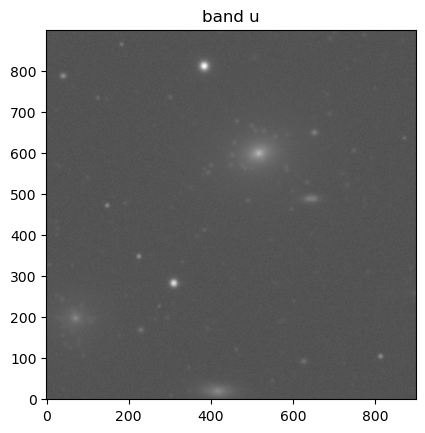

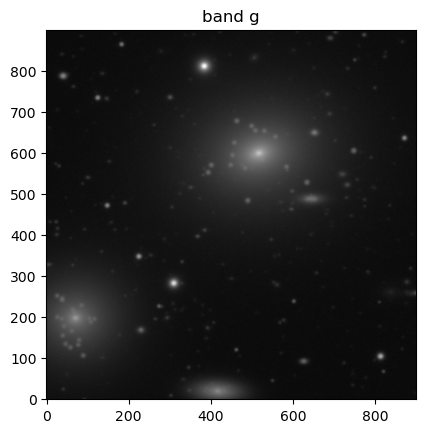

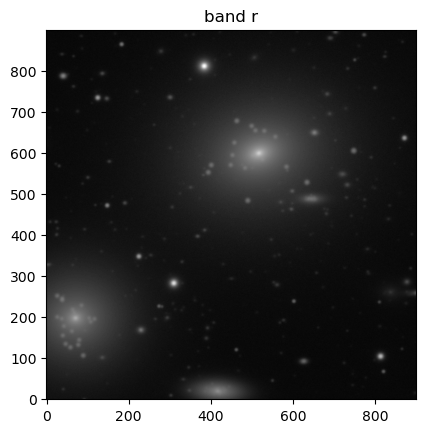

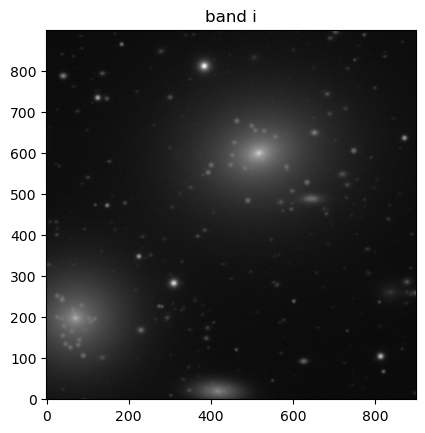

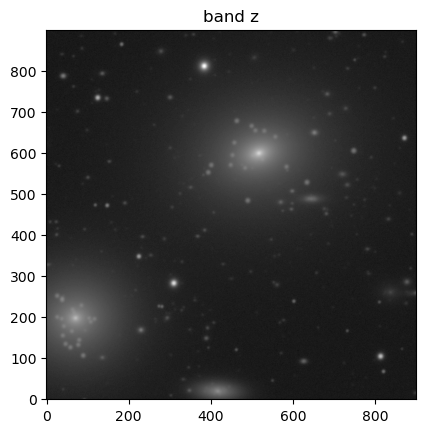

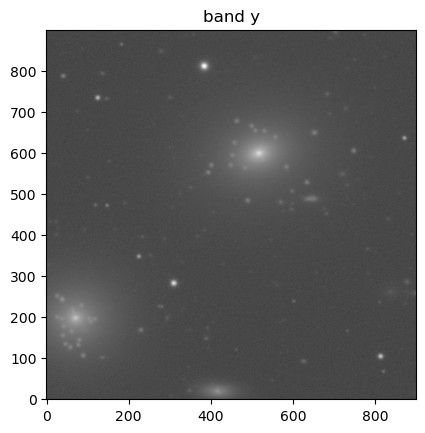

In [24]:
from astropy.visualization import ImageNormalize, AsinhStretch, ManualInterval
stretch = AsinhStretch(0.0001)
for b in 'ugrizy':
    interval = ManualInterval(vmin=-10, vmax=100)
    norm = ImageNormalize(stretch=stretch, interval=interval)
    plt.imshow(npy_dic[b]['afw_image'].image.array, norm=norm, origin='lower', cmap='gray')
    temp = truths[b][truths[b]['ob_type'] == 'star']
    # plt.scatter(temp['ra'], temp['dec'])
    plt.title(f'band {b}')
    plt.show()
    

In [126]:
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.meas.algorithms import KernelPsf
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
import lsst.meas.extensions.gaap
import lsst.meas.modelfit
import lsst.geom as geom
from lsst.geom import Point2D
from lsst.afw.geom import makeSkyWcs
from lsst.afw.table import SourceTable, Schema
import galsim
import coord
import numpy as np
from lsst.afw.image import MultibandExposure
from lsst.meas.extensions.scarlet import ScarletDeblendTask, updateCatalogFootprints
from lsst.afw.table import SourceCatalog

def measure_single_band(band, coadd_band_data, deblend_catalog_data, measureConfig, schema):
    detected_catalog = deblend_catalog_data.copy()
    measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)
    print(f"Measuring band {band}", flush=True)
    measureTask.run(measCat=detected_catalog, exposure=coadd_band_data)
    detected_catalog = detected_catalog.copy(True)
    return band, detected_catalog.asAstropy()

def measure_single_band_s(band, coadd_band_data, deblend_catalog_data, scarlet_model_data, measureConfig, schema):
    """Measure a single band - parallelizable function"""
    measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)
    print(f"Measuring band {band}", flush=True)
    updateCatalogFootprints(
        modelData=scarlet_model_data,
        catalog=deblend_catalog_data,
        band=band
    )
    print(f"Starting band {band}", flush=True)
    SIZE_LIMIT = 13000

    filteredCatalog = SourceCatalog(deblend_catalog_data.table.clone())
    for rec in deblend_catalog_data:
        footprint = rec.getFootprint()
        if (footprint is not None and footprint.getArea() <= SIZE_LIMIT) or rec.get('deblend_nChild') > 0:
            filteredCatalog.append(rec)
    
    print(f"Measuring {len(filteredCatalog)}/{len(deblend_catalog_data)} sources "
          f"(removed {len(deblend_catalog_data)-len(filteredCatalog)} large footprints)")

    measureTask.run(filteredCatalog, coadd_band_data)

    _catalog = SourceCatalog(filteredCatalog.table.clone())
    _catalog.extend(filteredCatalog, deep=True)
    print(f"Finished band {band}", flush=True)

    measureTask.run(deblend_catalog_data, coadd_band_data)
    _catalog = SourceCatalog(deblend_catalog_data.table.clone())
    _catalog.extend(deblend_catalog_data, deep=True)
    print(f"Finished band {band}", flush=True)
    return band, _catalog.asAstropy()

def run_lsst_pipe_multi(bands, exp, n_jobs=3, scarlet=True):
    """Run LSST pipeline with parallel measurements"""
    
    coadds = MultibandExposure.fromExposures(bands, exp)
    for i in range(len(bands)):
        coadds[bands[i]].setWcs(exp[i].getWcs())
        coadds[bands[i]].setPhotoCalib(exp[i].getPhotoCalib())

    schema = SourceCatalog.Table.makeMinimalSchema()
    raerr = schema.addField("coord_raErr", type="F")
    decerr = schema.addField("coord_decErr", type="F")

    detectionTask = SourceDetectionTask(schema=schema)
    if scarlet:
        config = ScarletDeblendTask.ConfigClass()
        deblendTask = ScarletDeblendTask(schema=schema, config=config)

    else:
        configDeblend = SourceDeblendTask.ConfigClass()
        deblendTask = SourceDeblendTask(schema=schema, config=configDeblend)
    
    pre_measurement_schema = deblendTask.schema
    base_schema = Schema()
    for item in pre_measurement_schema:
        field = item.field
        base_schema.addField(field)

    measureConfig = SingleFrameMeasurementTask.ConfigClass()
    measureConfig.plugins.names |= [
        "modelfit_DoubleShapeletPsfApprox",
        "modelfit_CModel",
        # "ext_gaap_GaapFlux",
    ]
    measureConfig.slots.modelFlux = "modelfit_CModel"
    # measureConfig.plugins["modelfit_CModel"].region.maxArea = 200

    measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

    table = SourceCatalog.Table.make(schema)
    print('Starting Detections', flush=True)

    detectionResult = detectionTask.run(table, coadds["i"])
    catalog = detectionResult.sources

    print('Starting Deblend', flush=True)
    if scarlet:
        deblendedCatalog, scarletModelData = deblendTask.deblend(coadds, catalog)
        print(len(deblendedCatalog))
        print(f'Starting Measurements (parallel with {n_jobs} jobs)', flush=True)
        job_args = []
        for band in 'i': ## temp
            job_args.append((
                band, 
                coadds[band],
                deblendedCatalog,
                scarletModelData,
                measureConfig,
                base_schema))
        
        # Run measurements in parallel
        results = Parallel(n_jobs=n_jobs, backend='loky')(
            delayed(measure_single_band_s)(*args) for args in job_args
        )
    else:
        deblendTask.run(coadds['i'], catalog)
        print(len(catalog))
        print(f'Starting Measurements (parallel with {n_jobs} jobs)', flush=True)
        job_args = []
        for band in bands: ## temp
            job_args.append((
                band, 
                coadds[band],
                catalog,
                measureConfig,
                base_schema))
        
        # Run measurements in parallel
        results = Parallel(n_jobs=n_jobs, backend='loky')(
            delayed(measure_single_band)(*args) for args in job_args
        )
        
    # Collect results
    outCatalog = {}
    for band, catalog in results:
        outCatalog[band] = catalog
    
    print('Measurements complete', flush=True)
    return outCatalog

cats = run_lsst_pipe_multi([b for b in sample.keys()], [afw_dic[i] for i in sample.keys()], scarlet=True)
# cats = run_lsst_pipe_multi([b for b in 'iu'], [afw_dic[i] for i in 'iu'])

Starting Detections


Starting Deblend


KeyboardInterrupt: 

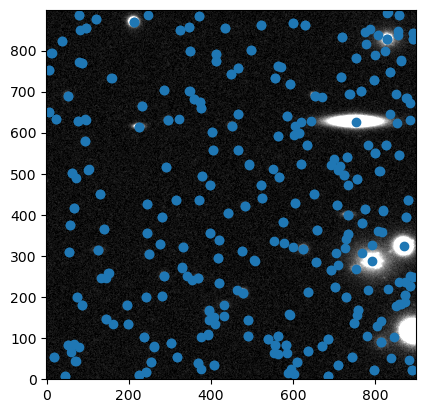

In [119]:
plt.imshow(npy_dic['i']['afw_image'].image.array, origin='lower', cmap='gray', vmin=-3,vmax=50)
plt.scatter(cats['i']['base_SdssCentroid_x'], cats['i']['base_SdssCentroid_y'])
plt.show()

In [72]:
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
from lsst.meas.algorithms import KernelPsf
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.algorithms.subtractBackground import SubtractBackgroundTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms import GaussianPsfFactory as psffac
import lsst.meas.extensions.gaap
import lsst.meas.modelfit
import lsst.geom as geom
from lsst.geom import Point2D
from lsst.afw.geom import makeSkyWcs
from lsst.afw.table import SourceTable
import galsim
import coord
import numpy as np

def run_lsst_pipe_single(exp, deblend=True):

    configDetection = SourceDetectionTask.ConfigClass()
    # configDetection.thresholdValue = 5
    # # configDetection.doTempLocalBackground = False
    # configDetection.reEstimateBackground = False

    # configDetection.thresholdType = "stdev"  # units for thresholdValue
    # # # configDetection.nSigmaToGrow = 1.0
    # # configDetection.nSigmaForKernel = 7
    # configDetection.minPixels = 2
    
    if deblend:
        configDeblend = SourceDeblendTask.ConfigClass()
    configMeasurement = SingleFrameMeasurementTask.ConfigClass()
    configMeasurement.plugins.names |= [
        "modelfit_DoubleShapeletPsfApprox",
        "modelfit_CModel",
        "ext_gaap_GaapFlux",
    ]
    configMeasurement.slots.modelFlux = "modelfit_CModel"

    schema = SourceTable.makeMinimalSchema()
    raerr = schema.addField("coord_raErr", type="F")
    decerr = schema.addField("coord_decErr", type="F")

    detect = SourceDetectionTask(schema=schema, config=configDetection)
    if deblend:
        deblender = SourceDeblendTask(schema=schema, config=configDeblend)
    #background = SubtractBackgroundTask() ?
    measure = SingleFrameMeasurementTask(schema=schema, config=configMeasurement)

    table = SourceTable.make(schema)
    detect_result = detect.run(table=table, exposure=exp)
    detected_catalog = detect_result.sources
    if deblend:
        deblender.run(exp, detected_catalog)
    measure.run(measCat=detected_catalog, exposure=exp)
    detected_catalog = detected_catalog.copy(True)

    # if deblend:
    #     return detected_catalog.asAstropy()[COLUMNS+['deblend_nChild']]  
    return detected_catalog.asAstropy()


In [65]:
from lsst.afw.image import MultibandExposure
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.extensions.scarlet import ScarletDeblendTask, updateCatalogFootprints
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.afw.table import SourceCatalog

In [85]:
print(afw_dic['i'].getPhotoCalib())
coadds = MultibandExposure.fromExposures(['i','r'],[afw_dic['i'],afw_dic['r']])
coadds['i'].setWcs(afw_dic['i'].getWcs())
print(coadds['i'].getPhotoCalib())

spatially constant with mean: 1 error: 0
None


In [96]:
# def run_lsst_pipe_multi(bands,exp):
#     coadds = MultibandExposure.fromExposures(bands, exp)

#     schema = SourceCatalog.Table.makeMinimalSchema()

#     detectionTask = SourceDetectionTask(schema=schema)
#     config = ScarletDeblendTask.ConfigClass()
#     config.maxIter = 300
#     deblendTask = ScarletDeblendTask(schema=schema, config=config)
    
#     measureConfig = SingleFrameMeasurementTask.ConfigClass()
#     # measureConfig.plugins.names |= [
#     #     "modelfit_DoubleShapeletPsfApprox",
#     #     "modelfit_CModel",
#     #     "ext_gaap_GaapFlux",
#     # ]
#     # measureConfig.slots.modelFlux = "modelfit_CModel"
#     measureConfig.plugins.names = ["base_SdssCentroid", "base_PsfFlux", "base_SkyCoord"]
#     # "Slots" are aliases that provide easy access to certain plugins.
#     # Because we're not running the plugin these slots refer to by default,
#     # we need to disable them in the configuration.
#     measureConfig.slots.apFlux = None
#     #measureConfig.slots.instFlux = None
#     measureConfig.slots.shape = None
#     measureConfig.slots.modelFlux = None
#     measureConfig.slots.calibFlux = None
#     measureConfig.slots.gaussianFlux = None
#     measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

#     table = SourceCatalog.Table.make(schema)
#     detectionResult = detectionTask.run(table, coadds["i"])
#     catalog = detectionResult.sources

#     templateCatalog = deblendTask.run(coadds, catalog)[0]
#     print(templateCatalog)
#     for i, f in enumerate(bands):
#         measureTask.run(templateCatalog, coadds[f])
    
#     # for i, f in enumerate(bands):
#     #     _catalog = SourceCatalog(templateCatalog[i].table.clone())
#     #     _catalog.extend(templateCatalog[i], deep=True)
#     #     outCatalog[f] = _catalog

#     return templateCatalog
def run_lsst_pipe_multi(bands,exp):
    coadds = MultibandExposure.fromExposures(bands, exp)
    for i in range(len(bands)):
        coadds[bands[i]].setWcs(exp[i].getWcs())
        coadds[bands[i]].setPhotoCalib(exp[i].getPhotoCalib())

    schema = SourceCatalog.Table.makeMinimalSchema()
    raerr = schema.addField("coord_raErr", type="F")
    decerr = schema.addField("coord_decErr", type="F")

    detectionTask = SourceDetectionTask(schema=schema)
    config = ScarletDeblendTask.ConfigClass()
    deblendTask = ScarletDeblendTask(schema=schema, config=config)
    
    measureConfig = SingleFrameMeasurementTask.ConfigClass()
    measureConfig.plugins.names |= [
        "modelfit_DoubleShapeletPsfApprox",
        "modelfit_CModel",
        "ext_gaap_GaapFlux",
    ]
    measureConfig.slots.modelFlux = "modelfit_CModel"
    
    measureTask = SingleFrameMeasurementTask(config=measureConfig, schema=schema)

    table = SourceCatalog.Table.make(schema)
    detectionResult = detectionTask.run(table, coadds["i"])
    catalog = detectionResult.sources
    
    deblendedCatalog, scarletModelData  = deblendTask.deblend(coadds, catalog)
    outCatalog = {}
    for band in bands:
        # Update footprints for this band
        updateCatalogFootprints(
            modelData=scarletModelData,
            catalog=deblendedCatalog,
            band=band
        )
        print(f"Measuring band {band}")
        measureTask.run(deblendedCatalog, coadds[band])

        _catalog = SourceCatalog(deblendedCatalog.table.clone())
        _catalog.extend(deblendedCatalog, deep=True)
        outCatalog[band] = _catalog.asAstropy()

    return outCatalog

In [97]:
# cat_i = run_lsst_pipe_single(afw_dic['i'])
cat_multi = run_lsst_pipe_multi(['i','r'],[afw_dic['i'],afw_dic['r']])

Measuring band i
Measuring band r


In [73]:
cat_i = run_lsst_pipe_single(afw_dic['i'])

In [ ]:
# import pickle
# with open('temp_afw_img.pickle', 'wb') as f:
    # pickle.dump(afw_dic, f)

In [47]:
import pickle
import numpy as np

run_path = '/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/outputs_vdiff_1_28/run_20260204T0543_582'
with open(f'{run_path}/ECDFS_sim_im.pkl', 'rb') as f:
    npy_dic = pickle.load(f)
# with open(f'{run_path}/ECDFS_sim_meas_forced.pkl', 'rb') as f:
#     cats = pickle.load(f)
# with open(f'{run_path}/ECDFS_sim_meas_forced_s.pkl', 'rb') as f:
#     cats_f = pickle.load(f)
with open(f'{run_path}/ECDFS_sim_truth.pkl', 'rb') as f:
    truths = pickle.load(f)

In [48]:
import dask.dataframe as dd
from utils import sample_diff_position
import astropy.units as u
from astropy.table import Table

ind = 582

diff_position = sample_diff_position(1001, 223, "/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/diffsky_1_28")
diff_ra = diff_position[ind-1][0]
diff_dec = diff_position[ind-1][1]

radius = (np.sqrt(2)*(900/2 + 2*50) * 0.2) * u.arcsec
radius_deg = radius.to(u.deg)
ra = diff_ra*u.degree
dec = diff_dec*u.degree
ra_min = ra - radius_deg / np.cos(np.deg2rad(dec))
ra_max = ra + radius_deg / np.cos(np.deg2rad(dec))
dec_min = dec - radius_deg
dec_max = dec + radius_deg

dataset = dd.read_parquet(f'/hildafs/home/pladuca/main/lsst-sim-package/LSST-SimCatVal/LSST-SimCatVal/diffsky_1_28/diffcat.parquet')

filt = dataset[((dataset["ra"] > ra_min.value) &
            (dataset["ra"] < ra_max.value) &
            (dataset["dec"] > dec_min.value) &
            (dataset["dec"] < dec_max.value))]

table = filt.compute()

galaxies = Table.from_pandas(table)

In [49]:
print(np.sort(galaxies['lsst_i_bulge']))

   lsst_i_bulge   
------------------
14.942186995401375
 17.84935185979586
 18.38309935740722
 18.56574179023465
 18.89364562246949
19.049853006546147
 19.11562143682391
19.259254388396872
19.388867205607713
  19.5380996956506
               ...
38.439261352572714
38.491931777005796
  38.6193235370516
 38.90296266530575
38.998171324656745
39.033478181679584
 39.61422880623985
39.703421002887524
 41.09366151530852
42.339059451400665
Length = 9250 rows


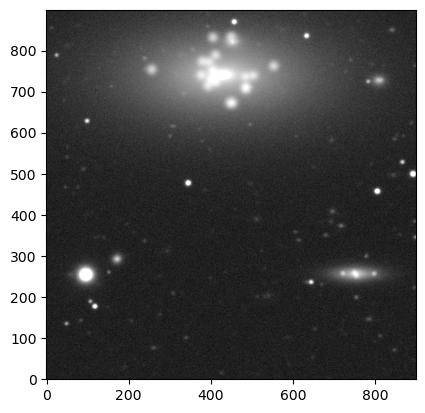

In [52]:
import matplotlib.pyplot as plt
from astropy.visualization import (
    ImageNormalize, 
    AsinhStretch, 
    PercentileInterval
)
norm = ImageNormalize(
    npy_dic['u']['afw_image'].image.array,
    interval=PercentileInterval(99.5),  # clip extremes
    stretch=AsinhStretch()
)

plt.imshow(npy_dic['u']['afw_image'].image.array, origin='lower', cmap='gray',norm=norm)
plt.show()

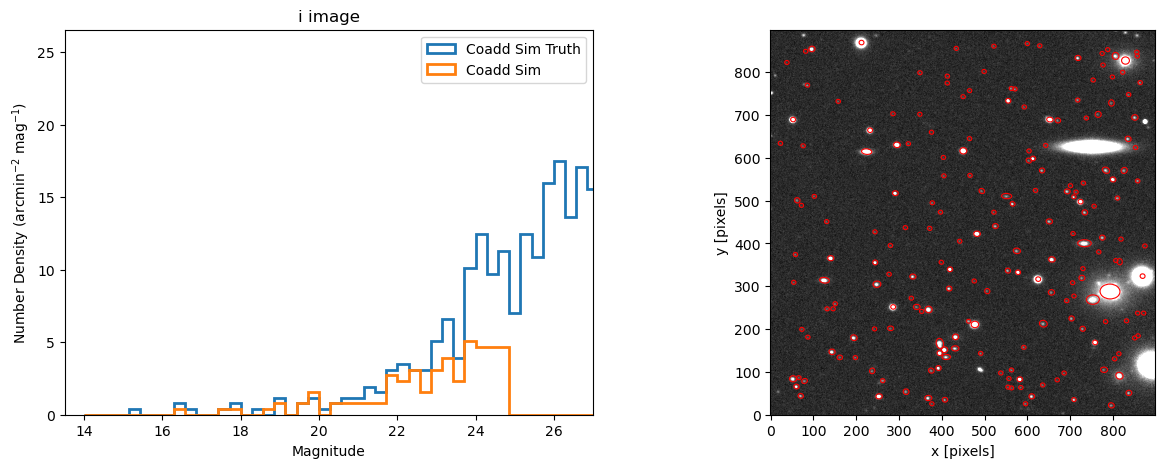

In [ ]:
from matplotlib.patches import Ellipse
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, AsinhStretch
import matplotlib.pyplot as plt

def make_some_plots(band, afw_img, cat, truth, cat_f=None):
    cat = cat[(cat['deblend_nChild'] == 0) &
              (cat['base_SdssShape_flag'] == False) &
              (cat['modelfit_CModel_instFlux'] >= 0) &
              (cat['modelfit_CModel_flag'] == False) &
              (cat['base_SdssCentroid_flag'] == False)]
    mag = -2.5 * np.log10(cat['modelfit_CModel_instFlux']) + 31.4
    snr = (cat['base_PsfFlux_instFlux']/cat['base_PsfFlux_instFluxErr'] >= 10)
    tmag = -2.5 * np.log10(truth[band]['flux']) + 31.4

    mag_bins = np.linspace(14, 28, 50)
    bin_size = mag_bins[1] - mag_bins[0]

    fig, ax = plt.subplots(1,2,figsize=(15,5))

    mag_weight = np.full_like(mag[snr], 1/((im_size * 0.2 /60)**2 *bin_size))
    
    tmag_weight = np.full_like(tmag, 1/((im_size * 0.2 /60)**2*bin_size))

    # ax[0].hist(dp1_m, dp1_b,weights=dp1_w,histtype="step",linewidth=2, label="Dp1")
    ax[0].hist(tmag, mag_bins,weights=tmag_weight,histtype="step",linewidth=2,label="Coadd Sim Truth")
    ax[0].hist(mag[snr], mag_bins,weights=mag_weight,histtype="step",linewidth=2,label="Coadd Sim")
    
    ax[0].set_xlabel("Magnitude")
    ax[0].set_ylabel("Number Density (arcmin$^{-2}$ mag$^{-1}$)")
    if band == 'u':
        ax[0].set_xlim(14,25)
        # ax[0].set_ylim(0,15)
    else:
        ax[0].set_xlim(13.5,27)
        # ax[0].set_ylim(0,30)
    # ax[0].set_yscale('log')

    ax[1].imshow(afw_img['afw_image'].image.array, origin='lower', cmap='gray', vmin=-10,vmax=50)
    # ax[1].set_xlim(0,1000)
    # ax[1].set_ylim(0,1000)
    for i in range(len(cat)):
        x = cat['base_SdssCentroid_x'][i]
        y = cat['base_SdssCentroid_y'][i]
        xx = cat['base_SdssShape_xx'][i]
        yy = cat['base_SdssShape_yy'][i]
        xy = cat['base_SdssShape_xy'][i]

        T = 0.5 * (xx + yy)
        D = np.sqrt(((xx - yy) / 2)**2 + xy**2)
        a = np.sqrt(T + D)
        b = np.sqrt(T - D)
        theta = 0.5 * np.arctan2(2 * xy, xx - yy)
        
        e = Ellipse((x, y), width=5*a, height=5*b,
                    angle=np.degrees(theta), edgecolor='red',
                    facecolor='none', lw=0.8)
        ax[1].add_patch(e)

    if cat_f is not None:
        cat_f = cat_f[(cat_f['deblend_nChild'] == 0) &
              (cat_f['base_SdssShape_flag'] == False) &
              (cat_f['modelfit_CModel_instFlux'] >= 0) &
              (cat_f['modelfit_CModel_flag'] == False) &
              (cat_f['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
              (cat_f['base_SdssCentroid_flag'] == False) &
              (cat_f['ext_gaap_GaapFlux_flag'] == False) &
              (cat_f['base_ClassificationSizeExtendedness_flag'] == False)]
        mag_f = -2.5 * np.log10(cat_f['modelfit_CModel_instFlux']) + 31.4
        snr_f = (cat_f['base_PsfFlux_instFlux']/cat_f['base_PsfFlux_instFluxErr'] >= 10)
        mag_weight_f = np.full_like(mag_f[snr_f], 1/((im_size * 0.2 /60)**2 *bin_size))
        ax[0].hist(mag_f[snr_f], mag_bins,weights=mag_weight_f,histtype="step",linewidth=2,label="Coadd Sim Forced")

        for i in range(len(cat_f)):
            x = cat_f['base_SdssCentroid_x'][i]
            y = cat_f['base_SdssCentroid_y'][i]
            xx = cat_f['base_SdssShape_xx'][i]
            yy = cat_f['base_SdssShape_yy'][i]
            xy = cat_f['base_SdssShape_xy'][i]

            T = 0.5 * (xx + yy)
            D = np.sqrt(((xx - yy) / 2)**2 + xy**2)
            a = np.sqrt(T + D)
            b = np.sqrt(T - D)
            theta = 0.5 * np.arctan2(2 * xy, xx - yy)
            
            e = Ellipse((x, y), width=5*a, height=5*b,
                        angle=np.degrees(theta), edgecolor='green',
                        facecolor='none', lw=0.8)
            ax[1].add_patch(e)
    ax[1].set_xlabel('x [pixels]')
    ax[1].set_ylabel('y [pixels]')
    ax[0].set_title(f'{band} image')
    ax[0].legend()
    plt.show()

    
# bands = 'ugirzy'
bands = 'i'
for b in bands:
    make_some_plots(b, npy_dic[b], cats[b], truths)#cat[b][cat[b]['modelfit_CModel_instFlux']/cat[b]['modelfit_CModel_instFluxErr'] > 0], truths)

#need to figure out how to account for area of the image if some images are partially off of the sim catalog region

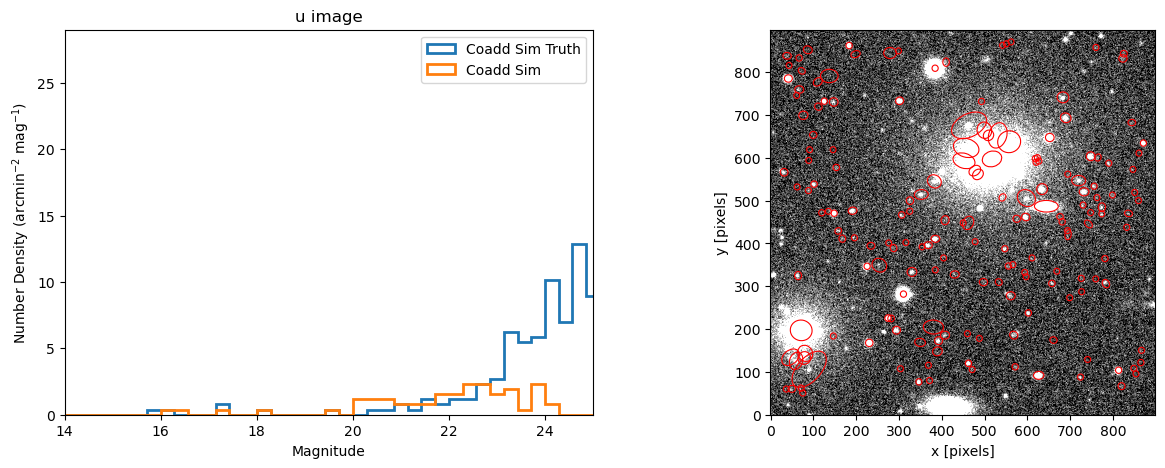

In [79]:
make_some_plots(b, npy_dic[b], cats[b], truths)

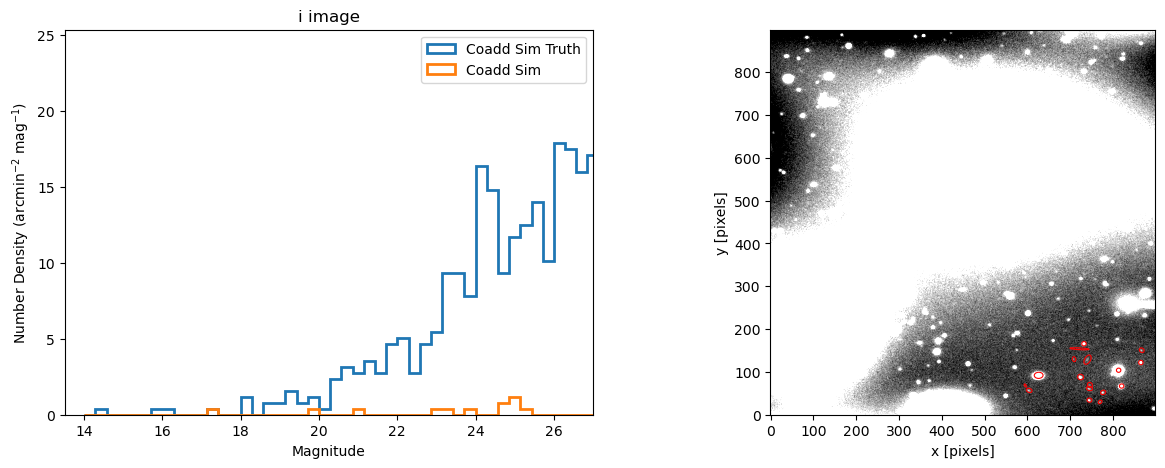

In [74]:
make_some_plots('i', npy_dic['i'], cat_i, truths)

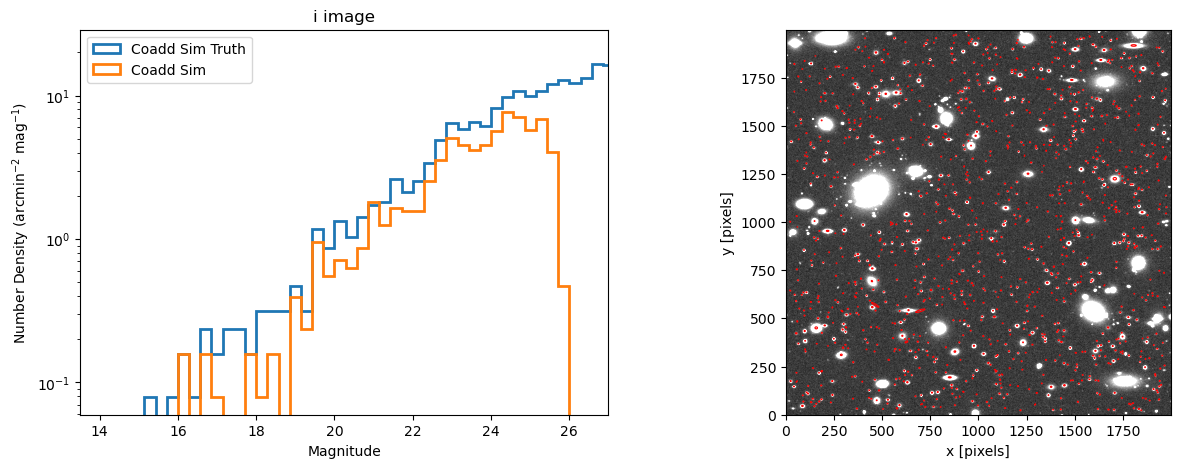

In [11]:
bands = 'i'
for b in bands:
    make_some_plots(b, npy_dic_[b], cats_[b], truths_)

(13.0, 28.0)

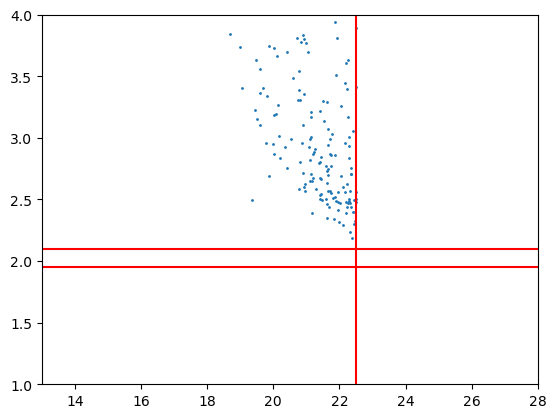

In [3]:
def cuts(cat):
    cat = cat[(cat['deblend_nChild'] == 0) &
              (cat['base_SdssShape_flag'] == False) &
              (cat['modelfit_CModel_instFlux'] >= 0) &
              (cat['modelfit_CModel_flag'] == False) &
              (cat['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
              (cat['base_SdssCentroid_flag'] == False) &
              (cat['ext_gaap_GaapFlux_flag'] == False) &
              (cat['base_ClassificationSizeExtendedness_flag'] == False)]
    snr = (cat['base_PsfFlux_instFlux']/cat['base_PsfFlux_instFluxErr'] >= 10) & ((-2.5 * np.log10(cat['modelfit_CModel_instFlux']) + 31.4)<=22.5)
    return cat[snr]

cut_i_ = cuts(cats_['i'])

mag = -2.5 * np.log10(cut_i_['modelfit_CModel_instFlux']) + 31.4
size = (cut_i_['base_SdssShape_xx']*cut_i_['base_SdssShape_yy'] - cut_i_['base_SdssShape_xy']**2)**0.25

plt.scatter(mag, size, s=1, alpha=1)
up = 2.1
down = 1.95
cut = 22.5

plt.axhline(up, c='r')
plt.axhline(down, c='r')
plt.axvline(cut, c='r')
stars_ = cut_i_[(mag < cut) & (size < up) & (size > down)]
gals_ = cut_i_[(size >= up)]

plt.ylim(1,4)
plt.xlim(13,28)

    

(13.0, 28.0)

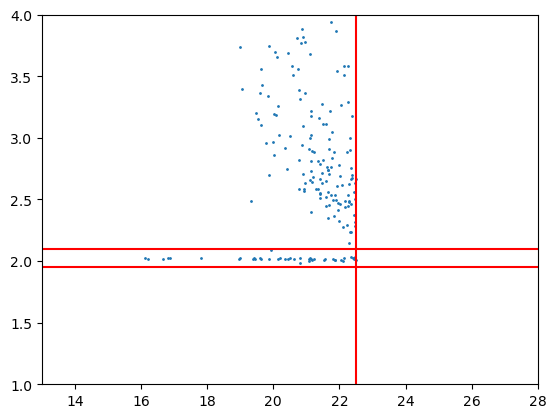

In [13]:
cut_i = cuts(cats_['i'])

mag = -2.5 * np.log10(cut_i['modelfit_CModel_instFlux']) + 31.4
size = (cut_i['base_SdssShape_xx']*cut_i['base_SdssShape_yy'] - cut_i['base_SdssShape_xy']**2)**0.25

plt.scatter(mag, size, s=1, alpha=1)
up = 2.1
down = 1.95
cut = 22.5

plt.axhline(up, c='r')
plt.axhline(down, c='r')
plt.axvline(cut, c='r')
stars = cut_i[(mag < cut) & (size < up) & (size > down)]
gals = cut_i[(size >= up)]

plt.ylim(1,4)
plt.xlim(13,28)

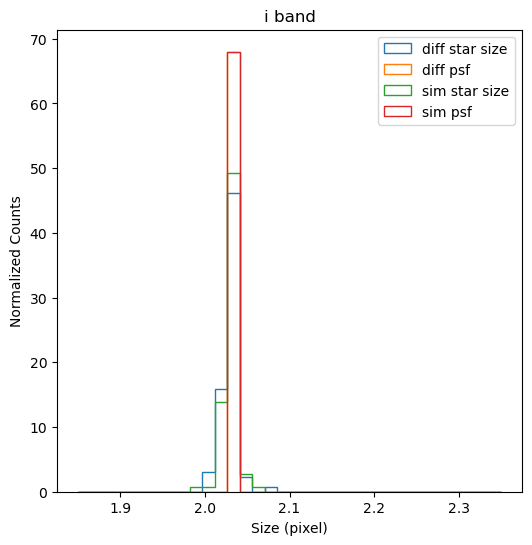

In [74]:
size_bins = np.linspace(1.85,2.35,35)
bin_size = size_bins[1] - size_bins[0]
# star_trace = np.sqrt(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
# star_psf_trace = np.sqrt(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
star_size = (stars['base_SdssShape_xx']*stars['base_SdssShape_yy'] - stars['base_SdssShape_xy']**2)**0.25
star_psf = (stars['base_SdssShape_psf_xx']*stars['base_SdssShape_psf_yy'] - stars['base_SdssShape_psf_xy']**2)**0.25
star_size_ = (stars_['base_SdssShape_xx']*stars_['base_SdssShape_yy'] - stars_['base_SdssShape_xy']**2)**0.25
star_psf_ = (stars_['base_SdssShape_psf_xx']*stars_['base_SdssShape_psf_yy'] - stars_['base_SdssShape_psf_xy']**2)**0.25
#test the size using the trace while using the detRad for the star selection

sim_weight = np.full_like(star_size, 1/((im_size * 0.2 /60)**2*bin_size))
dp1_weight = np.full_like(star_size_, 1/((im_size * 0.2 /60)**2*bin_size))

fig, ax = plt.subplots(figsize=(6,6))
# plt.hist(dp1_size[dp1_star], size_bins,weights=dp1_weight, histtype="step", label="dp1 star size")
# plt.hist(dp1_size_psf[dp1_star], size_bins,weights=dp1_weight, histtype="step", label="dp1 psf")
# plt.hist(star_size, size_bins,weights=sim_weight, histtype="step", label="sim star size")
# plt.hist(star_psf, size_bins,weights=sim_weight, histtype="step", label="sim psf")
plt.hist(star_size_,size_bins,density=True, histtype="step", label="diff star size")
plt.hist(star_psf_,size_bins,density=True, histtype="step", label="diff psf")
plt.hist(star_size, size_bins,density=True, histtype="step", label="sim star size")
plt.hist(star_psf, size_bins,density=True, histtype="step", label="sim psf")
plt.xlabel('Size (pixel)')
plt.ylabel('Normalized Counts')
plt.title(f'{b} band')
plt.legend()
# plt.grid()
plt.show()

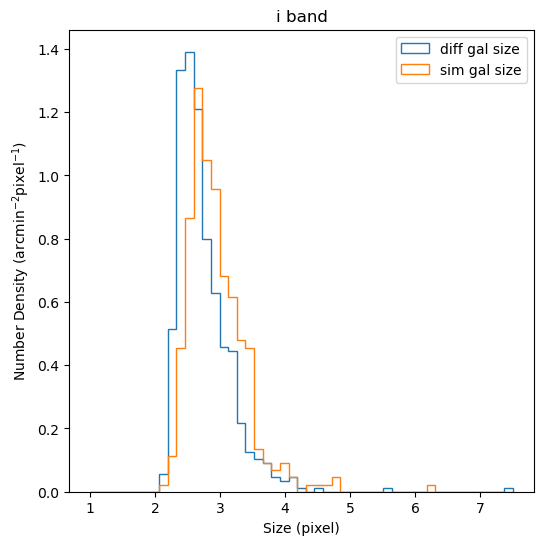

In [75]:
size_bins = np.linspace(1,7.5,50)
gal_size = (gals['base_SdssShape_xx']*gals['base_SdssShape_yy'] - gals['base_SdssShape_xy']**2)**0.25
gal_size_ = (gals_['base_SdssShape_xx']*gals_['base_SdssShape_yy'] - gals_['base_SdssShape_xy']**2)**0.25

bin_size = size_bins[1] - size_bins[0]
sim_weight = np.full_like(gal_size, 1/((im_size * 0.2 /60)**2*bin_size))
dp1_weight = np.full_like(gal_size_, 1/((im_size * 0.2 /60)**2*bin_size))

fig, ax = plt.subplots(figsize=(6,6))
# plt.hist(dp1_trace[dp1_mask], size_bins, weights=dp1_weight, histtype="step", label="dp1 gal size")
# plt.hist(gal_size, size_bins, weights=sim_weight, histtype="step", label="sim gal size")
plt.hist(gal_size_, size_bins, density=True, histtype="step", label="diff gal size")
plt.hist(gal_size, size_bins, density=True, histtype="step", label="sim gal size")
plt.xlabel('Size (pixel)')
plt.ylabel('Number Density (arcmin$^{-2} $pixel$^{-1}$)')
plt.legend()
plt.title(f'{b} band')
# plt.grid()
# plt.yscale('log')
plt.show()

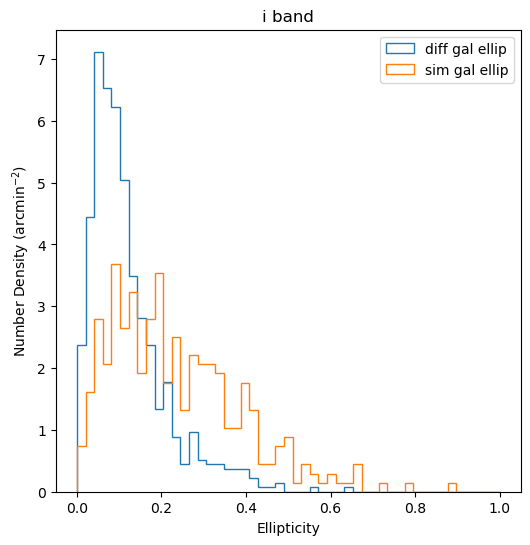

In [76]:
e1 = (gals['base_SdssShape_xx'] - gals['base_SdssShape_yy'])/(gals['base_SdssShape_xx'] + gals['base_SdssShape_yy'])
e2 = 2*(gals['base_SdssShape_xy'])/(gals['base_SdssShape_xx'] + gals['base_SdssShape_yy'])
ellip = np.sqrt((e1)**2 + (e2)**2)

e1_ = (gals_['base_SdssShape_xx'] - gals_['base_SdssShape_yy'])/(gals_['base_SdssShape_xx'] + gals_['base_SdssShape_yy'])
e2_ = 2*(gals_['base_SdssShape_xy'])/(gals_['base_SdssShape_xx'] + gals_['base_SdssShape_yy'])
ellip_ = np.sqrt((e1_)**2 + (e2_)**2)

ellip_bins = np.linspace(0,1,50)
bin_size = ellip_bins[1] - ellip_bins[0]
sim_weight = np.full_like(ellip, 1/((im_size * 0.2 /60)**2*bin_size))
dp1_weight = np.full_like(ellip_, 1/((im_size * 0.2 /60)**2*bin_size))

fig, ax = plt.subplots(figsize=(6,6))
# plt.hist(dsellip[dp1_mask], ellip_bins, weights=dp1_weight, histtype="step", label="dp1 gal ellip")
# plt.hist(ellip, ellip_bins, weights=sim_weight, histtype="step", label="sim gal ellip")
plt.hist(ellip_, ellip_bins, density=True, histtype="step", label="diff gal ellip")
plt.hist(ellip, ellip_bins, density=True, histtype="step", label="sim gal ellip")

plt.xlabel('Ellipticity')
plt.ylabel('Number Density (arcmin$^{-2}$)')
plt.legend()
plt.title(f'{b} band')
# plt.grid()
# plt.yscale('log')
plt.show()

/tmp/ipykernel_2545225/3798473225.py:17: RuntimeWarning: divide by zero encountered in divide
  diff_frac = diff / ghist_dp1
/tmp/ipykernel_2545225/3798473225.py:17: RuntimeWarning: invalid value encountered in divide
  diff_frac = diff / ghist_dp1


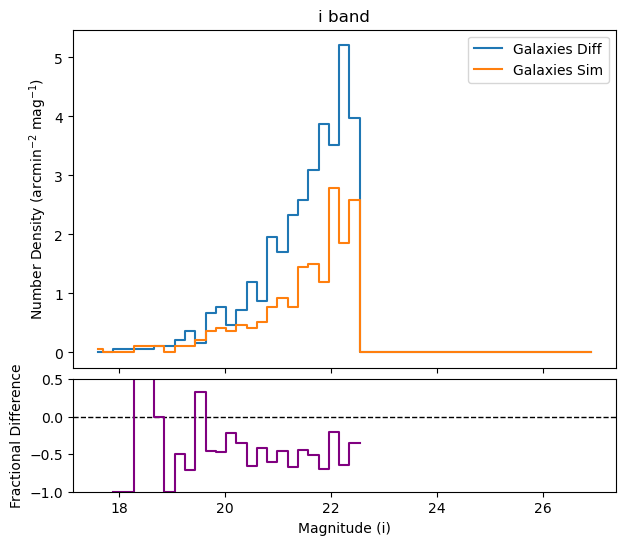

In [77]:
mag_bins = np.linspace(17.5, 27, 50)
bin_centers = 0.5 * (mag_bins[1:] + mag_bins[:-1])
bin_size = mag_bins[1] - mag_bins[0]

gal_mag = -2.5 * np.log10(gals['modelfit_CModel_instFlux']) + 31.4
gal_mag_ = -2.5 * np.log10(gals_['modelfit_CModel_instFlux']) + 31.4

sim_weight = np.full_like(gal_mag, 1/((3000*0.2/60)**2*bin_size))
sim_weight_ = np.full_like(gal_mag_, 1/((3000*0.2/60)**2*bin_size))

# Compute histograms (number density)
ghist_dp1, _ = np.histogram(gal_mag_, bins=mag_bins, weights=sim_weight_ )
ghist_sim, _ = np.histogram(gal_mag, bins=mag_bins, weights=sim_weight )

# Difference
diff = ghist_sim - ghist_dp1
diff_frac = diff / ghist_dp1

# Figure with two panels
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    figsize=(7, 6),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1], "hspace": 0.05}
)

# --- Top panel: histograms ---
ax_top.step(bin_centers, ghist_dp1, where="mid", label="Galaxies Diff")
ax_top.step(bin_centers, ghist_sim, where="mid", label="Galaxies Sim")
# ax_top.set_yscale("log")
ax_top.set_ylabel("Number Density (arcmin$^{-2}$ mag$^{-1}$)")
ax_top.legend()
ax_top.set_title(f"{b} band")

# --- Bottom panel: difference ---
ax_bot.axhline(0, color="k", lw=1, ls="--")
# ax_bot.axhline(0.1, color="k", lw=1, ls="--")
# ax_bot.axhline(-0.1, color="k", lw=1, ls="--")
ax_bot.step(bin_centers, diff_frac, where="mid", color="purple")
ax_bot.set_xlabel(f"Magnitude ({b})")
ax_bot.set_ylabel("Fractional Difference")
ax_bot.set_ylim(-1,0.5)

plt.show()

Text(0, 0.5, 'Galaxy Size (pixels)')

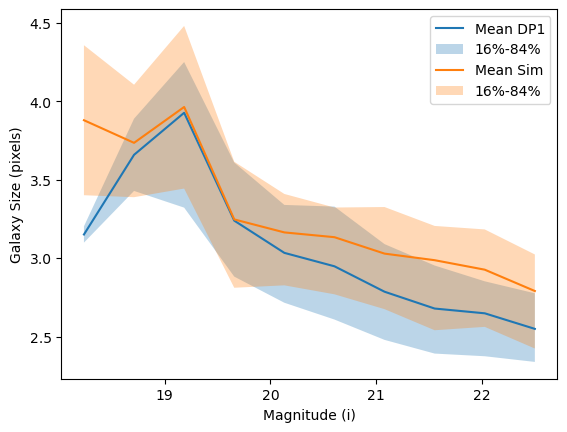

In [106]:
def percent_bins(x, y, bins):
    indices = np.digitize(x, bins)
    bin_centers = []
    y_means = []
    y_stds = []
    for i in range(1, len(bins)):
        mask = indices == i
        if np.sum(mask) > 0:
            bin_center = 0.5 * (bins[i-1] + bins[i])
            bin_centers.append(bin_center)
            y_means.append(np.mean(y[mask]))
            y_stds.append((np.percentile(y[mask], 16), np.percentile(y[mask], 84)))
        else:
            continue
    bin_centers = np.array(bin_centers)
    y_means = np.array(y_means)
    y_stds = np.array(y_stds)
    return bin_centers, y_means, y_stds

x, y, percents = percent_bins(gal_mag_,gal_size_,np.linspace(18, 27, 20))
plt.plot(x, y, label='Mean DP1')
plt.fill_between(x, percents[:,0], percents[:,1], alpha=0.3, label='16%-84%')
x, y, percents = percent_bins(gal_mag,gal_size,np.linspace(18, 27, 20))
plt.plot(x, y, label='Mean Sim')
plt.fill_between(x, percents[:,0], percents[:,1], alpha=0.3, label='16%-84%')
plt.legend()
plt.xlabel("Magnitude (i)")
plt.ylabel("Galaxy Size (pixels)")

Text(0, 0.5, 'Galaxy Size (pixels)')

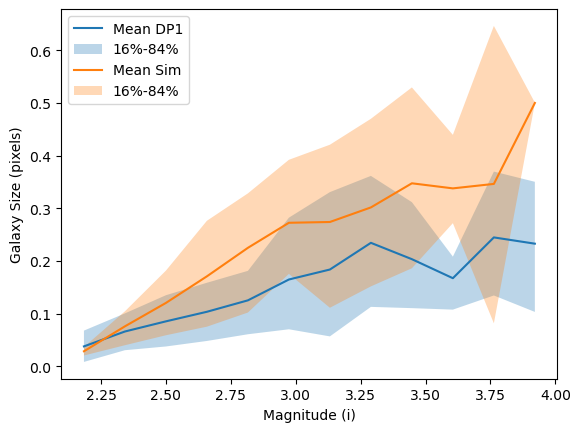

In [107]:
def percent_bins(x, y, bins):
    indices = np.digitize(x, bins)
    bin_centers = []
    y_means = []
    y_stds = []
    for i in range(1, len(bins)):
        mask = indices == i
        if np.sum(mask) > 1:
            bin_center = 0.5 * (bins[i-1] + bins[i])
            bin_centers.append(bin_center)
            y_means.append(np.mean(y[mask]))
            y_stds.append((np.percentile(y[mask], 16), np.percentile(y[mask], 84)))
        else:
            continue
    bin_centers = np.array(bin_centers)
    y_means = np.array(y_means)
    y_stds = np.array(y_stds)
    return bin_centers, y_means, y_stds

x, y, percents = percent_bins(gal_size_,ellip_,np.linspace(1, 4, 20))
plt.plot(x, y, label='Mean DP1')
plt.fill_between(x, percents[:,0], percents[:,1], alpha=0.3, label='16%-84%')
x, y, percents = percent_bins(gal_size,ellip,np.linspace(1, 4, 20))
plt.plot(x, y, label='Mean Sim')
plt.fill_between(x, percents[:,0], percents[:,1], alpha=0.3, label='16%-84%')
plt.legend()
plt.xlabel("Magnitude (i)")
plt.ylabel("Galaxy Size (pixels)")